# Multi-class Classification with Logistic Regression

For this exercise, you will use logistic regression to
recognize handwritten digits (from 0 to 9). Automated handwritten digit
recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This
exercise will show you how the methods you've learned can be used for this
classification task.
In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io import loadmat
%matplotlib inline

Our data are in a .mat format so we will use a SciPy utility loadmat to load it into Python

In [2]:
data = loadmat(r'C:\Users\Igor Kolasa\ML-exercises\ml_by_stanford_coursera\data\ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

There are 5000 training examples in ex3data1.mat, where each training
example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is
represented by a 
floating point number indicating the grayscale intensity at
that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional
vector. Each of these training examples becomes a single row in our data
matrix X. This gives us a 5000 by 400 matrix X where every row is a training
example for a handwritten digit image.
The second part of the training set is a 5000-dimensional vector y that
contains labels for the training set. The digit zero is mapped to the value ten. Therefore, a "0" digit is labeled as "10", while
the digits "1" to "9" are labeled as "1" to "9" in their natural order.


We can display choosen handwritten numbers from our dataset.

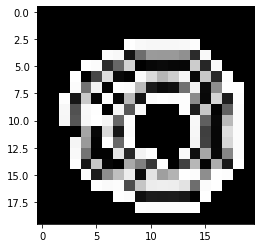

In [3]:
example_num = 5
img_arr = np.reshape(data['X'][example_num,:], (20,20))
img = Image.fromarray((img_arr * 255).astype('uint8'), mode='L')
plt.imshow(img, cmap='gray')

Implement sigmoid function

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

We'll implement vectorized functions for computing cost and gradient as we did in the previous exercises.

In [5]:
def compute_cost_reg(theta, X, y, lamb):

    # Number of training examples
    m = X.shape[0]

    # Sigmoid function input
    z = np.dot(X, theta)

    # Hypothesis (sigmoid function)
    h = sigmoid(z)

    # Regularization term (we don't regularize theta[0])
    reg_term = (lamb/(2*m))*np.dot(theta[1:].T, theta[1:])
    
    # Compute cost
    left = np.dot(-y.T, np.log(h))
    right = np.dot((1-y).T, np.log(1-h))
    J = (left - right) / m + reg_term
    
    return J.item() 

In [6]:
def gradient_reg(theta, X, y, lamb):
    
    # Must reshape theta back to 2D because fmin_tnc 
    # truncates it to 1D
    theta = np.reshape(theta, (-1, 1)) # (28, 1) 

    grad = np.zeros_like(theta)

    # Number of training examples
    m = X.shape[0]

    # Sigmoid function input
    z = np.dot(X, theta)

    # Hypothesis (sigmoid function)
    h = sigmoid(z)

    # Compute grad
    theta[0] = 0
    error = h - y
    reg_term = (lamb/m)*theta
    grad = np.dot(X.T, error) / m + reg_term
    
    return grad

We will implement one-vs-all classification by
training multiple regularized logistic regression classifiers, one for each of
the K classes in our dataset. 
One_vs_all function will train one classifier for
each class. The code will return all the classifier parameters
in a matrix all_theta, where each row of all_theta corresponds to the learned
logistic regression parameters for one class.

In [7]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, lamb):
    
    # m - number of rows, n - number of columns
    m = X.shape[0]
    n = X.shape[1]

    # Initialize theta matrix, add additional column 
    # for the intercept term
    all_theta = np.zeros((num_labels, n+1))

    # Add column of ones to X matrix
    X = np.insert(X, 0, 1, axis=1)

    # Set initial theta
    init_theta = np.zeros((n+1,1))

    # Obtain the optimal theta
    # Note that labels are 1-indexed
    for i in range(1,num_labels):
        y_i = np.where(y == i, 1, 0)
        fmin = minimize(fun=compute_cost_reg, x0=init_theta, args=(X, y_i, lamb), method='TNC', jac=gradient_reg)
        all_theta[i-1,:] = fmin.x

    return all_theta

Let's train our classifier on the provided dataset

In [8]:
num_labels = 10
lambd = 0.1
all_theta = one_vs_all(data['X'], data['y'], num_labels, lambd)
print(all_theta)
all_theta.shape

[[-3.07552353e+00  0.00000000e+00  0.00000000e+00 ...  6.82774044e-03
   1.20093161e-10  0.00000000e+00]
 [-3.73234600e+00  0.00000000e+00  0.00000000e+00 ...  2.33138800e-02
  -2.55729048e-03  0.00000000e+00]
 [-5.71373793e+00  0.00000000e+00  0.00000000e+00 ... -6.28973487e-05
  -3.60997330e-07  0.00000000e+00]
 ...
 [-9.12416903e+00  0.00000000e+00  0.00000000e+00 ... -6.16423956e-04
   6.95631343e-05  0.00000000e+00]
 [-5.62333564e+00  0.00000000e+00  0.00000000e+00 ... -1.12430552e-02
   8.54861551e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


(10, 401)

After training our one-vs-all classifier, we can now use it to predict the
digit contained in a given image. For each input, we will compute the
"probability" that it belongs to each class using the trained logistic regression
classifiers. Our one-vs-all prediction function will pick the class for which the
corresponding logistic regression classifier outputs the highest probability and
return the class label (1, 2,..., or K) as the prediction for the input example.

In [9]:
def predict_one_vs_all(X, all_theta):
    
    # Insert column of ones to X
    X = np.insert(X, 0, 1, axis=1)

    # Compute probability matrix
    prob = np.dot(X, all_theta.T)

    # Compute predictions matrix 
    # (For each row in prob matrix choose 
    # the column index with the highest probability)
    predicts = np.argmax(prob, axis=1)
    predicts += 1

    # Convert predicts 1D array to 2D column vector
    predicts = np.atleast_2d(predicts).T

    return predicts

In [10]:
predicts = predict_one_vs_all(data['X'], all_theta)
predicts

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [10]], dtype=int64)

Let's compute our training set accuracy

In [11]:
train_accuracy = np.mean(predicts == data['y']) * 100
print('Training Set Accuracy: {train_accuracy}%'.format(train_accuracy=train_accuracy))

Training Set Accuracy: 91.78%


We can see that our model classifies 91.78% of the examples in the training set correctly. We should of course run it on the separate test set to obtain its accuarcy on the unseen data, but this was beyond the scope of this exercise.